# How to Continue Making a Wormhole

## Part 2: Majorana Fermions and SYK

To approach SYK (the Sachdev-Ye-Kitaev) model, first we need to recall about fermions.

As you may know, we (often) classify particles in terms of whether they are bosons or fermions. Generally speaking, bosons are like force particles: examples are the photon, the gluon. Any number of bosons can be in the same state: hence, a laser beam. The bosonic particles are in themselves indistinguishable: they are permutation symmetric. We can use quantum harmonic oscillators to easily keep track of bosonic degrees of freedom. We assign a harmonic oscillator to each degree of freedom of the particle, and the number operator of each oscillator keeps track of how many particles are in *that state*. The use of harmonic oscillators automatically imposes for us that the particles be permutation symmetric. 

For each oscillator, we have "creation" and "annihilation" operators, which add and subtract quanta from each oscillator--and although they are not themselves hermitian, they can be used as building blocks for hermitian operators. If we have multiple oscillators, we can just tensor these creation and annihilation operators with identities so they act on the appropriate subspaces. These operators obey the following commutation relations:

$$ [b_{i}, b_{j}] = [b^{\dagger}_{i}, b^{\dagger}_{j}] = 0 $$
$$ [b_{i}, b^{\dagger}_{j}] = \delta_{ij} $$

Where \\( b^{\dagger} \\) is a creation operator, \\( b \\) is an annihilation operator, and: the commutator is \\( [A, B] = AB - BA \\). 

If we want to do the same thing for fermions, we have to make some changes. First, our oscillators can only have 0 or 1 excitations. In other words, at maximum only 1 fermion can be in a given state. This is the Pauli exclusion principle at work. Indeed, the tensor product has to work differently: the whole thing has to do with how fermions are permutation *antisymmetric* particles, unlike bosons which are permutation *symmetric*. So it doesn't matter the order in which we create bosons, but for fermions: \\( f^{\dagger}_{i} f^{\dagger}_{j} \mid 0 \rangle = -f^{\dagger}_{j} f^{\dagger}_{i} \mid 0 \rangle \\), where \\( \mid 0 \rangle \\) is the fermion vacuum aka the state of all oscillators having 0 quanta.

The upshot is that the commutation relations between fermions involve the anticommutator instead of the commutator. The anticommutator is \\( \{A, B\} = AB + BA \\).

$$ \{f_{i}, f_{j}\} = \{f^{\dagger}_{i}, f^{\dagger}_{j}\} = 0 $$
$$ \{f_{i}, f^{\dagger}_{j}\} = \delta^{i,j} $$

It's not hard to implement this. Suppose we have 5 fermions. The standard 2x2 matrices for creation and annihilation operators are just:

$$ f^{\dagger} = \begin{pmatrix} 0 & 0 \\ 1 & 0 \end{pmatrix} $$
$$ f = \begin{pmatrix} 0 & 1 \\ 0 & 0 \end{pmatrix} $$

To construct, for example, 5 pairs of creation and annihilation operators with the correct commutation relations, and so which preserve the antisymmetry of the fermions:

$$ f_{0} = f \otimes I \otimes I \otimes I \otimes I $$
$$ f_{1} = Z \otimes f \otimes I \otimes I \otimes I $$
$$ f_{2} = Z \otimes Z \otimes f \otimes I \otimes I $$
$$ f_{3} = Z \otimes Z \otimes Z \otimes f \otimes I $$
$$ f_{4} = Z \otimes Z \otimes Z \otimes Z \otimes f $$

Where $Z$ is Pauli $Z$. The idea is that there is a "normal ordering" for the fermions. When the operators are applied to the vacuum in the descending order, the $Z$'s in \\( f_{4} \\), say, don't matter since there are no excitations in those oscillators: we're in the vacuum after all. But when the operators are applied in the reverse order, they pick up a negative sign from the $Z$'s. You can check that this works


In [1]:
import qutip as qt
import numpy as np

def fermion_operators(n):
    return [qt.tensor(*[qt.destroy(2) if i == j\
                else (qt.sigmaz() if j < i\
                    else qt.identity(2))\
                        for j in range(n)])\
                            for i in range(n)]

def anticommutator(a, b):
    return a*b + b*a

def test_fermions(f):
    d = f[0].shape[0]
    for i in range(len(f)):
        for j in range(len(f)):
            test1 = anticommutator(f[i], f[j]).full()
            test2 = anticommutator(f[i], f[j].dag()).full()
            if not \
                (np.isclose(test1, np.zeros((d,d))).all()\
                    and \
                ((np.isclose(test2, np.zeros((d,d))).all() and i != j)\
                        or (np.isclose(test2, np.eye(d)).all() and i == j))):
                return False
    return True

#########################################################################################

n = 4
f = fermion_operators(n)
fvac = qt.basis(2**n)
fvac.dims = [[2]*n, [1]*n]

print("testing fermion operators: %s" % test_fermions(f))

testing fermion operators: True


So we have some fermions. Now we're going to do a crazy thing. It turns out we can split a fermion into two "Majorana fermions." The idea is that a Majorana fermion is its own antiparticle: its creation and annihilation operators *are the same operator*. In some sense, we can think of them like the "square roots" of normal fermions. At the same time, if we swap the order of Majorana operators, we pick up a negative sign, and so we are justified in calling them fermions.

Given normal fermion operators \\(f\\) and \\(f^{\dagger}\\), we form Majorana operators:

$$ \psi_{L} = f + f^{\dagger} $$
$$ \psi_{R} = i(f - f^{\dagger}) $$

Here \\( \psi \\) is the standard way of referring to a Majorana operator. We've chosen to call the two Majoranas we get  by "left" and "right" for reasons we shall shortly see. And by the way, they are hermitian.

So we we have $n$ fermions, we could imagine splitting them all into Majoranas. Given our choice of normalization, they'll obey the commutation relations:

$$ \{ \psi_{i}, \psi_{j} \}  = 2\delta_{ij}$$

In [2]:
def split_fermion(f):
    return (f + f.dag()), 1j*(f - f.dag())

def test_majoranas(m):
    d = m[0].shape[0]
    for i in range(len(m)):
        for j in range(len(m)):
            test = anticommutator(m[i], m[j]).full()
            if not ((i == j and np.isclose(test, 2*np.eye(d)).all()) or\
                    (i != j and np.isclose(test, np.zeros((d,d))).all())):
                return False
    return True

#########################################################################################

m = []
for i in range(n):
    m.extend(split_fermion(f[i]))

print("testing majorana operators: %s" % test_majoranas(m))
print("anticommutes?: %s" % (m[2]*m[1]*fvac == -m[1]*m[2]*fvac))
print("is own antiparticle?: %s" % (m[0]*m[0]*fvac == fvac))

testing majorana operators: True
anticommutes?: True
is own antiparticle?: True


We've seen how in the case of $n$ qubits, strings of $n$ Pauli's form a basis for hermitian/unitary operators. Something quite analogous works here with the Majoranas. If we have $n$ Majoranas, we can take all combinations of them of lengths $0,1,2,3,\dots$ up to $n$, and these form an operator basis. In other words, we consider all combinations of Majoranas of different lengths (eg. \\( I, \psi_{0}, \psi_{1}, \psi_{2}, \psi_{0}\psi_{1}, \psi_{0}\psi_{2}, \psi_{1}\psi_{2}, \psi_{0}\psi_{1}\psi_{2} \\)) and take the inner product of our operator with each of them in turn. (In fact, due to our normalization convention, we'll be rescaling each of these operators by $2^{-\frac{m}{4}}$, where $m$ is the number of Majoranas.) We can then recover the original operator by multiplying each of the obtained coefficients by the Majorana string operators and summing.

In [3]:
from itertools import combinations
from functools import reduce 

def majorana_basis(m):
    n = len(m)
    prefac = 2**(-n/4)
    M = {}
    for i in range(n+1):
        if i == 0:
            M["I"] = prefac*qt.identity(m[0].shape[0])
            M["I"].dims = m[0].dims
        else:
            for string in combinations(list(range(n)), i):
                M[string] = prefac*reduce(lambda x, y: x*y, [m[j] for j in string])
    return M

def op_coeffs(O, M):
    return dict([(string, (string_op.dag()*O).tr()) for string, string_op in M.items()])

def coeffs_op(coeffs, M):
    return sum([coeffs[string]*string_op for string, string_op in M.items()])

def prettyc(coeffs):
    for string, coeff in coeffs.items():
        if not np.isclose(coeff, 0):
            print("%s : %s" % (string, coeff))

#########################################################################################

M = majorana_basis(m)
O = qt.rand_herm(2**n)
O.dims = [[2]*n, [2]*n]
Oc = op_coeffs(O, M)
O2 = coeffs_op(Oc, M)

print("Recovered operator? %s" % (O == O2))
#print("Expansion in Majoranas:")
#prettyc(Oc)

Recovered operator? True


<hr>

Just we can split a normal fermion into two Majoranas, we can combine any two Majoranas into a normal fermion. This turns out to be a pretty powerful idea!

In other words, if we have Majoranas $\psi_{L}$ and $\psi_{R}$:

$$ f = \frac{1}{2}(\psi_{L} + i\psi_{R}) $$
$$ f^{\dagger} = \frac{1}{2}(\psi_{L} - i\psi_{R}) $$

Indeed, $\psi_{L}$ and $\psi_{R}$ could have originally come from two different normal fermions to begin with, only to end up combined in $f$.

Now here's an interesting thing to do. 

Suppose have $2n$ normal fermions, and we call the first $n$ "left fermions" and the second $n$ "right fermions." We could split the left fermions into $2n$ Majoranas, and split the right fermions into $2n$ Majoranas. We could then create $2n$ new normal fermions, which we'll call "complex fermions," which are each built out of one left Majorana and one right Majorana.

Concretely, suppose we started with 2 normal fermions, so we have one on the left and one on the right: $f_{L}$ and $f_{R}$. We split them into Majoranas: 

$$\psi_{L,0} = f_{L} + f_{L}^{\dagger}$$

$$\psi_{L,1} = i(f_{L} - f_{L}^{\dagger})$$

$$\psi_{R,0} = f_{R} + f_{R}^{\dagger}$$

$$\psi_{R,1} = i(f_{R} - f_{R}^{\dagger})$$

Finally, we combine Majoranas *across left and right* to obtain complex fermions: 

$$c_{0} = \frac{1}{2}(\psi_{L, 0} + i\psi_{R, 0})$$

$$c_{1} = \frac{1}{2}(\psi_{L, 1} + i\psi_{R, 1})$$

The upshot is that the vacuum state of these complex fermions is a maximally entangled state of the original fermions across left and right.

In [4]:
def join_majoranas(m, n):
    return (1/2)*(m + 1j*n)#, (1/2)*(m - 1j*n)

#########################################################################################

N = 2*n
lr = fermion_operators(N)

mL = []
for i in range(n): 
    mL.extend(split_fermion(lr[i]))

mR = []
for i in range(n, N): 
    mR.extend(split_fermion(lr[i]))

cf = [join_majoranas(mL[i], mR[i]) for i in range(N)]

print("testing left and right fermions: %s" % test_fermions(lr))
print("testing majoranas: %s" % test_majoranas(mL+mR))
print("testing complex fermions: %s" % test_fermions(cf))
print()

N_lr = sum([lr[i].dag()*lr[i] for i in range(N)])
N_c = sum([cf[i].dag()*cf[i] for i in range(N)])

lr_vac = qt.basis(2**N, 0)
lr_vac.dims = [[2]*N, [1]*N]

N_cL, N_cV = N_c.eigenstates()
c_vac = N_cV[0]

print("<N_lr> on lr_vac = %f" % qt.expect(N_lr, lr_vac))
print("<N_c> on lr_vac = %f" % qt.expect(N_c, lr_vac))
print("<N_lr> on c_vac = %f" % qt.expect(N_lr, c_vac))
print("<N_c> on c_vac = %f" % qt.expect(N_c, c_vac))
print()

L = c_vac.ptrace(list(range(0, n)))
R = c_vac.ptrace(list(range(n, N)))
print("L c_vac entropy: %f" % qt.entropy_vn(L))
print("R c_vac entropy: %f" % qt.entropy_vn(R))
print("max possible entropy: %f" % qt.entropy_vn(qt.identity(2**n)/2**n))
print()

testing left and right fermions: True
testing majoranas: True
testing complex fermions: True

<N_lr> on lr_vac = 0.000000
<N_c> on lr_vac = 4.000000
<N_lr> on c_vac = 4.000000
<N_c> on c_vac = -0.000000

L c_vac entropy: 2.772589
R c_vac entropy: 2.772589
max possible entropy: 2.772589



It's worth noting that alternatively, we could have started with $N$ normal fermions and treated those, right off the bat, as our complex fermions. We could have split each of the $N$ into two Majoranas, $\psi_{L, i}$ and $\psi_{R, i}$, and then grouped the left Majoranas and the right Majoranas together, and built our normal left fermions out of adjacent Majoranas on the left, and our normal right Majoranas out of adjacent Majoranas on the right. This would have the benefit that the complex fermion vacuum would just be the usual vacuum vector, with a $1$ in the first place followed all by $0$'s, and moreover, that the total number operator of the complex fermions would be diagonal. (Whereas in the above construction, it's the total number operator of the left/right normal fermions that's diagonal.) The downside is that it's less easy to take a partial trace over left and right to find the entanglement entropy. 

<hr>

So it's an interesting fact that if we're in the vacuum state of the complex fermions, this corresponds to a maximally entangled state across left and right. In other words, the vacuum of the complex fermions corresponds to a left/right CUP state. This means we can play all of our usual games with string diagrams. 

Indeed, we've seen how we can turn an operator into a state by acting with that operator on one half of the maximally entangled cup state. An operator on the left becomes splayed out across left and right as a state: indeed, we saw in our discussion of quantum teleportation, if we're working in the standard basis, the components of the resulting vector are literally the components of the operator matrix unraveled.

Moreover, we can take an operator and slide it down around a cup. If we had a bead on a string, and we slid it around a bend, the bead would end up flipped on the other side. Indeed, when we slide an operator around a bend, we saw that we had to take the transpose. Or in other words: we get the same state if a) we act on the left half of the cup with an operator or b) if instead we act on the right half by the transpose of the original operator.

<img width=200 src="img/cup_slide.png">

Here, with our Majoranas, something a little different occurs: we don't take the transpose of the original operator, instead it suffices to multiply all the right Majoranas by $-i$! Somehow we've traded a 90 degree rotation of the matrix for a 90 degree rotation in the complex plane. It makes sense insofar as in each original fermion lives a left and a right part, each separated by a mere local rotation.

Note that we have to be a little careful in terms of upgrading an operator to act on the left or right due to the fermonic sign flips. So to be safe: if we had an operator on $n$ fermions that we wanted to act on the left or right of $2n$ fermions,  we decompose the operator in a basis of $2n$ Majoranas, obtaining coefficients, and then go in reverse, using the $2n$ Majoranas (out of $4n$) corresponding to the left/right Majoranas, multiplying those operators by the coefficients and summing.

In [6]:
O = qt.rand_unitary(2**n)
O.dims = [[2]*n, [2]*n]
Oc = op_coeffs(O, M)

ML = majorana_basis(mL)
MR = majorana_basis([-1j*m_ for m_ in mR])

OL = coeffs_op(Oc, ML)
OR = coeffs_op(Oc, MR)

print("OL*c_vac == OR*c_vac: %s" % (OL*c_vac==OR*c_vac))
print("Even as: OL != OR: %s" % (OL!=OR))

OL*c_vac == OR*c_vac: True
Even as: OL != OR: True


<hr>

Now before in our wormhole adventures, we sort of waved our hands when it came to choosing the coupling operator between the two sides, saying that the $ZZ$ coupling is a good proxy for a "size" operator. Here there is a literal size operator which we can use, and miraculously perhaps, it turns out to be simply: *the total number operator of the complex fermions*, which are built out of left and right. Moreover, the individual number operators of the complex fermions count the number of individual Majoranas operators themselves "inside" the operator.

The construction is that we take an operator that acts on half the fermions, upgrade it to a double sided state by acting on the left on the maximally entangled left/right state corresponding to the "complex fermion vacuum," and then looking at the expectation value of the complex fermion number operator(s) on that state to get the size. Easy as pie!

In [7]:
def size(O, i=None):
    global M, ML, N_c, cf, c_vac
    majorana_state = coeffs_op(op_coeffs(O, M), ML)*c_vac
    if type(i) == type(None):
        return qt.expect(N_c, majorana_state)
    else:
        return qt.expect(cf[i].dag()*cf[i], majorana_state)

#########################################################################################

print("size of m[0]: %f" % size(m[0]))
print("size of m[1]*m[0]: %f" % size(m[1]*m[0]))
print("size of m[2]*m[1]*m[0]: %f" % size(m[2]*m[1]*m[0]))
print()

print("# of m[0] in m[2]*m[1]*m[0]: %f" % size(m[2]*m[1]*m[0], i=0))
print("# of m[1] in m[2]*m[1]*m[0]: %f" % size(m[2]*m[1]*m[0], i=1))
print("# of m[2] in m[2]*m[1]*m[0]: %f" % size(m[2]*m[1]*m[0], i=2))
print("# of m[3] in m[2]*m[1]*m[0]: %f" % size(m[2]*m[1]*m[0], i=3))

size of m[0]: 1.000000
size of m[1]*m[0]: 2.000000
size of m[2]*m[1]*m[0]: 3.000000

# of m[0] in m[2]*m[1]*m[0]: 1.000000
# of m[1] in m[2]*m[1]*m[0]: 1.000000
# of m[2] in m[2]*m[1]*m[0]: 1.000000
# of m[3] in m[2]*m[1]*m[0]: 0.000000


<hr>

Now we're ready to define the SYK hamiltonian.

$$ H_{SYK} = -\frac{1}{4!} \sum_{i}^{m} \sum_{j}^{m} \sum_{k}^{m} \sum_{l}^{m} c_{i,j,k,l} \psi_{i}\psi_{j}\psi_{k}\psi_{l} $$ 

for \\( i < j < k < l \\).

It's a sum of four way interactions between Majorana fermions, in other words, the interactions are 4-local. The coefficients are normally distributed. The point is that the SYK model is highly scrambling: in fact, in the limit of many Majoranas, it demonstrates "perfect size winding." For these reasons, people use it to model black holes, which are believed to be the "fasted scramblers" in nature. In other words, its dynamics will take localized states to highly nonlocalized states very quickly: an operators supported on just a few fermions will in general end up supported across all of them in no time.

In the context of our double sized wormhole, before, once we decided on an energy operator $H_{L}$, we took $H_{R} = H_{L}^{T}$. Here we do the same thing, choosing SYK coefficients, and then building the left Hamiltonian out of the left Majoranas, and the right Hamiltonian out of $-i$ times the right Majoranas.

In [9]:
import math

def random_syk_couplings(m):
    J = {}
    for i in range(m):
        for j in range(m):
            for k in range(m):
                for l in range(m):
                    if i < j and j < k and k < l:
                        J[(i, j, k, l)] = np.random.normal()
    return J

def syk_ham(couplings, m):
    Jterms = []
    for ijkl, c in couplings.items():
        i, j, k, l = ijkl
        Jterms.append(c*m[i]*m[j]*m[k]*m[l])
    return (-1/(math.factorial(4)))*sum(Jterms)

#########################################################################################

SYK = random_syk_couplings(N)
H = syk_ham(SYK, m)
HL = syk_ham(SYK, mL)
HR = syk_ham(SYK, [-1j*m_ for m_ in mR]) 

Now we can evolve our operator \\( O \\) in time! And just as before, we can see that by construction, acting on the left with $O$ in the past is equivalent to acting with $O$ on the right in the future.

In [11]:
OLt = lambda t: (1j*HL*t).expm()*OL*(-1j*HL*t).expm()
ORt = lambda t: (1j*HR*t).expm()*OR*(-1j*HR*t).expm()

print(OLt(-10)*c_vac == ORt(10)*c_vac)

True


Similarly, we can construct the TFD state at inverse temperature \\( \beta \\) by "splaying" \\( \rho \\) across left and right.

In [16]:
def construct_thermal_dm(H, beta=0):
    return (-beta*H).expm()/(-beta*H).expm().tr()

def construct_tfd(H, beta=0):
    rho_ = (-beta*H*(1/2)).expm()/np.sqrt((-beta*H*(1/2)).expm().tr())
    rhoL = coeffs_op(op_coeffs(rho_, M), ML)
    return (rhoL*c_vac).unit()
    
beta = 1
rho = construct_thermal_dm(H, beta=beta)
TFD = construct_tfd(H, beta=beta)

print("left partial of TFD is rho?: %s" % (rho == TFD.ptrace(list(range(int(N/2))))))
print("right partial of TFD is rho?: %s" % (rho == TFD.ptrace(list(range(int(N/2), N)))))

left partial of TFD is rho?: True
right partial of TFD is rho?: True


Recall that the TFD at infinite temperature $\beta = 0$ is just the maximally entangled state (complex fermion vacuum) that we started with. We can use the TFD at some finite temperature to get a temperature dependent notion of size!

In [19]:
def cold_size(O, i=None):
    global M, ML, N_c, cf, TFD
    majorana_state = coeffs_op(op_coeffs(O, M), ML)*TFD
    if type(i) == type(None):
        return qt.expect(N_c, majorana_state)
    else:
        return qt.expect(cf[i].dag()*cf[i], majorana_state)

#########################################################################################

print("size of m[0]: %f" % cold_size(m[0]))
print("size of m[1]*m[0]: %f" % cold_size(m[1]*m[0]))
print("size of m[2]*m[1]*m[0]: %f" % cold_size(m[2]*m[1]*m[0]))
print()

print("# of m[0] in m[2]*m[1]*m[0]: %f" % cold_size(m[2]*m[1]*m[0], i=0))
print("# of m[1] in m[2]*m[1]*m[0]: %f" % cold_size(m[2]*m[1]*m[0], i=1))
print("# of m[2] in m[2]*m[1]*m[0]: %f" % cold_size(m[2]*m[1]*m[0], i=2))
print("# of m[3] in m[2]*m[1]*m[0]: %f" % cold_size(m[2]*m[1]*m[0], i=3))

size of m[0]: 1.088500
size of m[1]*m[0]: 2.062598
size of m[2]*m[1]*m[0]: 3.032963

# of m[0] in m[2]*m[1]*m[0]: 0.984606
# of m[1] in m[2]*m[1]*m[0]: 0.987049
# of m[2] in m[2]*m[1]*m[0]: 0.985182
# of m[3] in m[2]*m[1]*m[0]: 0.018073


<hr>

Now we have to have some way of throwing a qubit into our wormhole.

Before we used a SWAP operation to insert our message qubit into the left black hole, which in any case was made of qubits. But that doesn't make much sense here. We could imagine swapping our qubit for the leftmost fermion, but that's kind of weird since although both qubits and fermionic oscillators live in 2D Hilbert spaces, they have different interpretations: in the case of a spin, the basis vectors refer to spin along or against the axis of quantization, and in the case of an oscillator, the basis vectors refer to the number of excitations, 0 or 1. 

But there is an elegant solution. It turns out, just as we can form a complex fermion out of two Majoranas, we can form a qubit out of three Majoranas! 

If we have three Majoranas denoted $\psi_{x}, \psi_{y}, \psi_{z}$, we can construct a representation of the Pauli operators:

$$ X = -i\psi_{x}\psi_{z} $$
$$ Y = -i\psi_{z}\psi_{y} $$
$$ Z = -i\psi_{y}\psi_{x} $$

These indeed follow the correct commutation relations.

$$ [X, Y] = 2iZ $$
$$ [Y, Z] = 2iX $$
$$ [Z, X] = 2iY $$
$$ [X, X] = [Y, Y] = [Z, Z] = 0 $$

So we could form XYZ operators out of the first three Majoranas on the left side, and the first three Majoranas on the right side.

In [20]:
def majoranas_qubit(m):
    I = qt.identity(m[0].shape[0])
    I.dims = m[0].dims
    return {"I": I,
            "X": -1j*m[0]*m[2],\
            "Y": -1j*m[2]*m[1],\
            "Z": -1j*m[1]*m[0]}

def test_XYZ(XYZ):
    return [qt.commutator(XYZ["X"], XYZ["Y"]) == 2j*XYZ["Z"],\
            qt.commutator(XYZ["Y"], XYZ["Z"]) == 2j*XYZ["X"],\
            qt.commutator(XYZ["Z"], XYZ["X"]) == 2j*XYZ["Y"],\
            qt.commutator(XYZ["X"], XYZ["X"]) == qt.commutator(XYZ["Y"], XYZ["Y"])\
                                              == qt.commutator(XYZ["Z"], XYZ["Z"]),\
            qt.commutator(XYZ["X"], XYZ["X"]).norm() == 0]

def qubit_xyz(state, XYZ):
    return np.array([qt.expect(XYZ["X"], state),\
                     qt.expect(XYZ["Y"], state),\
                     qt.expect(XYZ["Z"], state)])

#########################################################################################

XYZ_L = majoranas_qubit(mL[:3])
XYZ_R = majoranas_qubit(mR[:3])

print("testing XYZ_L: %s" % test_XYZ(XYZ_L))
print("testing XYZ_R: %s" % test_XYZ(XYZ_R))

testing XYZ_L: [True, True, True, True, True]
testing XYZ_R: [True, True, True, True, True]


<hr>

Cool! So now let's make a message qubit, for simplicity, in the spin up state.

In [31]:
IDrest = qt.identity(2**N)
IDrest.dims = [[2]*N, [2]*N]

msg = qt.basis(2,0)
state = qt.tensor(msg, TFD)

XYZ_msg = {"I": qt.tensor(qt.identity(2), IDrest),\
           "X": qt.tensor(qt.sigmax(), IDrest),\
           "Y": qt.tensor(qt.sigmay(), IDrest),\
           "Z": qt.tensor(qt.sigmaz(), IDrest)}

XYZ_L_ = dict([(op_name, qt.tensor(qt.identity(2), op)) for op_name, op in XYZ_L.items()])
XYZ_R_ = dict([(op_name, qt.tensor(qt.identity(2), op)) for op_name, op in XYZ_R.items()])

But wait, how do we implement our swap?

Well, here's an idea. We can take the usual swap operator on two qubits and express it in the Pauli basis. We have two sets Pauli matrices for the message qubit and the left black hole qubit, and so we can rebuild the swap operator out of them!

In [32]:
from itertools import product
from qutip.qip.operations.gates import swap

def pauli_basis(n):
    IXYZ = {"I": qt.identity(2), "X": qt.sigmax(), "Y": qt.sigmay(), "Z": qt.sigmaz()}
    return dict([("".join(P), qt.tensor(*[IXYZ[p]/2 for p in P])) for P in product(IXYZ, repeat=n)])

############################################

P = pauli_basis(2)
SWAP = swap(N=2, targets=[0,1])
SWAPc = op_coeffs(SWAP, P)
INSERT = sum([coeff*XYZ_msg[op_name[0]]*XYZ_L_[op_name[1]] for op_name, coeff in SWAPc.items()])

print("before swap:")
print(" msg qubit: %s" % np.round(qubit_xyz(state, XYZ_msg)))
print("   L qubit: %s" % np.round(qubit_xyz(state, XYZ_L_)))

print("\nafter swap:")
print(" msg qubit: %s" % np.round(qubit_xyz(INSERT*state, XYZ_msg)))
print("   L qubit: %s" % np.round(qubit_xyz(INSERT*state, XYZ_L_)))

print("\nswap again:")
print(" msg qubit: %s" % np.round(qubit_xyz(INSERT*INSERT*state, XYZ_msg)))
print("   L qubit: %s" % np.round(qubit_xyz(INSERT*INSERT*state, XYZ_L_)))

before swap:
 msg qubit: [0. 0. 1.]
   L qubit: [ 0. -0.  0.]

after swap:
 msg qubit: [ 0. -0.  0.]
   L qubit: [0. 0. 1.]

swap again:
 msg qubit: [0. 0. 1.]
   L qubit: [ 0. -0.  0.]


<hr>

So now we have all the ingredients in place. Morally speaking, we should skip over the first two complex fermions in our coupling operator since they're being used for the incoming/outgoing qubit--it, of course, works better if we don't!

final R qubit: [-0.02626367 -0.03790176  0.49358206]


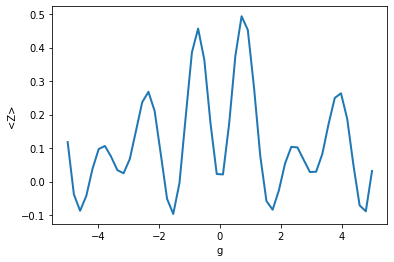

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

HL_ = qt.tensor(qt.identity(2), HL)
HR_ = qt.tensor(qt.identity(2), HR)
SIZE = qt.tensor(qt.identity(2), sum([cf_.dag()*cf_ for cf_ in cf[2:]]))

def wormhole(state, g, t=10):
    global HL, HR, SIZE
    return (-1j*HR_*t).expm()*(1j*g*SIZE).expm()*(-1j*HL_*t).expm()*INSERT*(1j*HL_*t).expm()*state

G = np.linspace(-5, 5, 50)
Z = [qt.expect(XYZ_R_["Z"], wormhole(state, g)) for g in G]
g = G[np.argmax(Z)] # since we started with the msg being [0,0,1]

final_state = wormhole(state, g)
final_qubit = qubit_xyz(final_state, XYZ_R_)

print("final R qubit: %s" % final_qubit)
plt.plot(G, Z, linewidth=2.0)
plt.xlabel("g")
plt.ylabel("<Z>")
plt.show()

And there you have it. We iterate over possible values $g$ of the coupling, evolving backwards in time on the left, swapping in our message, evolving forward in time on the left, coupling the two sides, then evolving forward in time on the right, finally examining the XYZ expectation values of the right qubit.

It's not that accurate, but then again we're only using a handful of fermions!

For more: see [syk_animated.py](examples/syk_animated.py).

<hr>

## Bibliography

<a href="https://arxiv.org/abs/1911.06314">Quantum Gravity in the Lab: Teleportation by Size and Traversable Wormholes</a>

<a href="https://arxiv.org/abs/1810.11958">Quantum Epidemiology: Operator Growth, Thermal Effects, and SYK</a>

<a href="https://arxiv.org/abs/1911.07416">A Traversable Wormhole Teleportation Protocol in the SYK Model</a>

